# Imports

In [95]:
import sys
print("python version =",sys.version[:5])

import os
import numpy as np
import xarray as xr
import pandas as pd
import dask as dsk
from dask.diagnostics import ProgressBar
import xesmf as xe
from tqdm import tqdm
import gsw as gsw

# plotting packages
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo
from cmocean.tools import lighten

print("numpy version =", np.__version__)
print("xarray version =", xr.__version__)
print("dask version =", dsk.__version__)
print("pandas version =", pd.__version__)
print("xesmf version =", xe.__version__)
print("matplotlib version =", sys.modules[plt.__package__].__version__)
print("cartopy version =", sys.modules[ccrs.__package__].__version__)
print("cmocean version =", sys.modules[cmo.__package__].__version__)

wrkdir = "/expanse/lustre/projects/ciw112/pbuchanan/JRA55"
os.chdir(wrkdir)
os.getcwd()

ProgressBar().register()

python version = 3.10.
numpy version = 1.26.4
xarray version = 2024.3.0
dask version = 2023.3.0
pandas version = 2.2.2
xesmf version = 0.8.7
matplotlib version = 3.7.1
cartopy version = 0.23.0
cmocean version = v3.0.3


# load data

In [96]:
phy_vars = ['thetao', 'so', 'mldr10_1', 'e3t']
bgc_vars = ['Age', 'O2', 'DIC', 'DIC_13', 'area']

### PIC ###
print("Loading PIC experiment data")
print("  Doing BGC variables")
bgc = xr.open_dataset("JRA55_pic_1y_ptrc_T_1958-2022.nc")[bgc_vars]
bgc_SEpac = xr.open_dataset("JRA55_SEPac_1y_ptrc_T_1958-2022.nc")[bgc_vars]
bgc_SWpac = xr.open_dataset("JRA55_SWPac_1y_ptrc_T_1958-2022.nc")[bgc_vars]
bgc_SEind = xr.open_dataset("JRA55_SEInd_1y_ptrc_T_1958-2022.nc")[bgc_vars]
bgc_SWind = xr.open_dataset("JRA55_SWInd_1y_ptrc_T_1958-2022.nc")[bgc_vars]
print("  Doing Physical variables")
phy = xr.open_dataset("JRA55_pic_1m_grid_T_1958-2022.nc")[phy_vars]
phy_SEpac = xr.open_dataset("JRA55_SEPac_1m_grid_T_Y2022.nc")[phy_vars]
phy_SWpac = xr.open_dataset("JRA55_SWPac_1m_grid_T_Y2022.nc")[phy_vars]
phy_SEind = xr.open_dataset("JRA55_SEInd_1m_grid_T_Y2022.nc")[phy_vars]
phy_SWind = xr.open_dataset("JRA55_SWInd_1m_grid_T_Y2022.nc")[phy_vars]


# calcualte d13C of DIC
print("  Doing d13C of DIC")
bgc['d13C_DIC'] = (bgc['DIC_13'] / bgc['DIC'] - 1.0)*1000.0
bgc_SEpac['d13C_DIC'] = (bgc_SEpac['DIC_13'] / bgc_SEpac['DIC'] - 1.0)*1000.0
bgc_SWpac['d13C_DIC'] = (bgc_SWpac['DIC_13'] / bgc_SWpac['DIC'] - 1.0)*1000.0
bgc_SEind['d13C_DIC'] = (bgc_SEind['DIC_13'] / bgc_SEind['DIC'] - 1.0)*1000.0
bgc_SWind['d13C_DIC'] = (bgc_SWind['DIC_13'] / bgc_SWind['DIC'] - 1.0)*1000.0


# rename time dimension to year
print( "  Rename dimensions")
phy = phy.rename({"time_counter":"month", "record":"year"})
phy_SEpac = phy_SEpac.rename({"time_counter":"month"})
phy_SWpac = phy_SWpac.rename({"time_counter":"month"})
phy_SEind = phy_SEind.rename({"time_counter":"month"})
phy_SWind = phy_SWind.rename({"time_counter":"month"})

bgc = bgc.rename({"time_counter":"year"})
bgc_SEpac = bgc_SEpac.rename({"time_counter":"year"})
bgc_SWpac = bgc_SWpac.rename({"time_counter":"year"})
bgc_SEind = bgc_SEind.rename({"time_counter":"year"})
bgc_SWind = bgc_SWind.rename({"time_counter":"year"})



Loading PIC experiment data
  Doing BGC variables
  Doing Physical variables
  Doing d13C of DIC
  Rename dimensions


# Detrend the data?

    Dont detrend. Because we have forced the ocean from the top for 65 years, the maximum increase in ventilation should be of the order ~ 65 years, unless displacement of a very old water mass occurs in space, which can cause greater aging. Anyway, if the atmospheric forcing is causing a top-down stratification of the ocean, then this should cause a downstream (interior) aging of the ocean.

    ... Actually... find out what drift there is in the deep ocean

<xarray.DataArray 'polyfit_coefficients' ()> Size: 8B
array(23.21584353)
Coordinates:
    degree   int64 8B 1
Take off 16 years from changes in age in plots


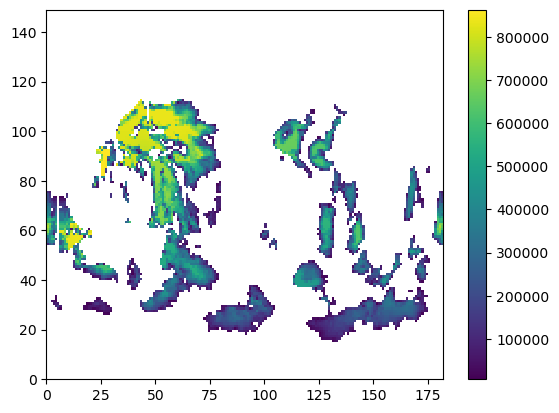

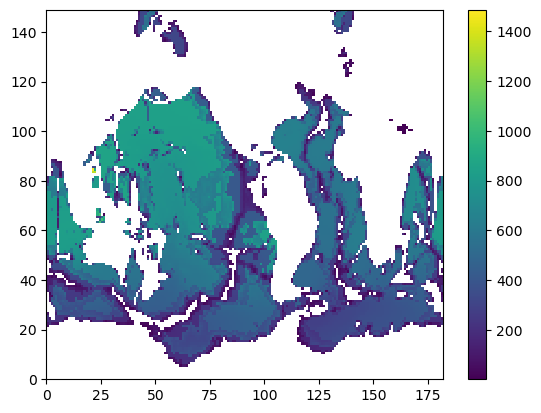

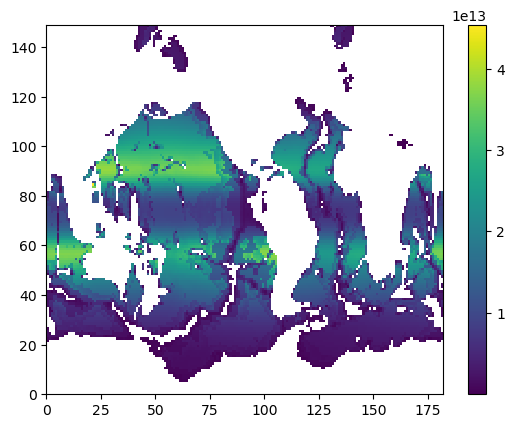

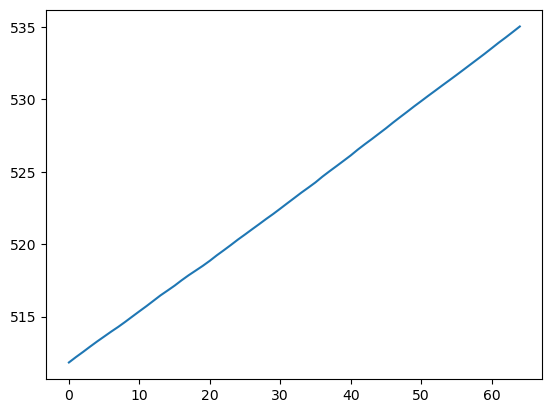

In [143]:
tmp = bgc['Age'].where(bgc['Age'] > 0.0, other=np.nan)
thick = phy['e3t'].where(phy['e3t']>0.0, other=np.nan).mean(dim='month')
area = bgc['area'].where(bgc['area'] > 0.0, other=np.nan)

deep_sum = (tmp*thick)

plt.figure()
plt.pcolormesh(deep_sum.isel(year=0, deptht=29))
plt.colorbar()

deep_vals = deep_sum.isel(deptht=slice(-5,30)).sum(dim=['deptht'], skipna=True) / thick.isel(deptht=slice(-5,30)).sum(dim=['deptht'], skipna=True)
deep_vals = deep_vals.where(deep_vals > 0.0, other=np.nan)

plt.figure()
plt.pcolormesh(deep_vals.isel(year=0))
plt.colorbar()

deep_area = deep_vals * area

plt.figure()
plt.pcolormesh(deep_area.isel(year=0))
plt.colorbar()


deep_vals = (deep_area).sum(dim=['x','y'], skipna=True) / area.where(deep_area > 0.0, other=np.nan).sum(dim=['x','y'], skipna=True)

deep_vals = deep_vals.assign_coords({"year":np.arange(0,65,1)})
slope = deep_vals.polyfit(dim='year', deg=1)['polyfit_coefficients']
print(slope[0]*64)

plt.figure()
plt.plot(deep_vals)

age_drift = deep_vals.isel(year=slice(-20,64)).mean(dim='year') - deep_vals.isel(year=slice(0,20)).mean(dim='year')
print("Take off %i years from changes in age in plots"%(age_drift))


# Calculate potential density

In [138]:
def calc_rho0(data):
    print("  Calculating absolute salinity and conservative temperature")
    data['asal'] = gsw.SA_from_SP(data['so'], data.coords['deptht'], data.coords['nav_lon'], data.coords['nav_lat'])
    data['ctem'] = gsw.CT_from_pt(data['asal'], data['thetao'])
    print("  Calculating rho0")
    data['rho0'] = gsw.density.sigma0(data['asal'], data['ctem'])
    print("  Masking potential density where it is 0.0")
    data['rho0'] = data['rho0'].where(data['rho0'] > 0.0, other=np.nan)
    return data
    
phy = calc_rho0(phy)
phy_SEpac = calc_rho0(phy_SEpac)
phy_SWpac = calc_rho0(phy_SWpac)
phy_SEind = calc_rho0(phy_SEind)
phy_SWind = calc_rho0(phy_SWind)



  Calculating absolute salinity and conservative temperature
  Calculating rho0
  Masking potential density where it is 0.0
  Calculating absolute salinity and conservative temperature
  Calculating rho0
  Masking potential density where it is 0.0
  Calculating absolute salinity and conservative temperature
  Calculating rho0
  Masking potential density where it is 0.0
  Calculating absolute salinity and conservative temperature
  Calculating rho0
  Masking potential density where it is 0.0
  Calculating absolute salinity and conservative temperature
  Calculating rho0
  Masking potential density where it is 0.0


# Regrid the data

In [141]:
### create the rectilinear grid
ds_out = xe.util.grid_global(1,1)
print(ds_out)

# regrid the curvilinear --> rectilinear
regridder = xe.Regridder(phy, ds_out, 'bilinear', ignore_degenerate=True)

def phys_regrid(data, regridder):
    print("  Regridding temperature")
    temp = regridder(data.thetao)
    print("  Regridding salinity")
    salt = regridder(data.so)
    print("  Regridding mixed layer depth")
    mld = regridder(data.mldr10_1)
    print("  Regridding potential density")
    rho0 = regridder(data.rho0)
    return temp, salt, mld, rho0
    
def bgc_regrid(data, regridder):
    print("  Regridding age")
    age = regridder(data.Age)
    print("  Regridding DIC")
    dic = regridder(data.DIC)
    print("  Regridding delta13C")
    d13c = regridder(data.d13C_DIC)
    return age, dic, d13c

temp, salt, mld, rho0 = phys_regrid(phy, regridder)
temp_SEpac, salt_SEpac, mld_SEpac, rho0_SEpac = phys_regrid(phy_SEpac, regridder)
temp_SWpac, salt_SWpac, mld_SWpac, rho0_SWpac = phys_regrid(phy_SWpac, regridder)
temp_SEind, salt_SEind, mld_SEind, rho0_SEind = phys_regrid(phy_SEind, regridder)
temp_SWind, salt_SWind, mld_SWind, rho0_SWind = phys_regrid(phy_SWind, regridder)

age, dic, d13c = bgc_regrid(bgc, regridder)
age_SEpac, dic_SEpac, d13c_SEpac = bgc_regrid(bgc_SEpac, regridder)
age_SWpac, dic_SWpac, d13c_SWpac = bgc_regrid(bgc_SWpac, regridder)
age_SEind, dic_SEind, d13c_SEind = bgc_regrid(bgc_SEind, regridder)
age_SWind, dic_SWind, d13c_SWind = bgc_regrid(bgc_SWind, regridder)


<xarray.Dataset> Size: 2MB
Dimensions:  (y: 180, x: 360, y_b: 181, x_b: 361)
Coordinates:
    lon      (y, x) float64 518kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
    lat      (y, x) float64 518kB -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5
    lon_b    (y_b, x_b) float64 523kB -180.0 -179.0 -178.0 ... 178.0 179.0 180.0
    lat_b    (y_b, x_b) float64 523kB -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0
Dimensions without coordinates: y, x, y_b, x_b
Data variables:
    *empty*
  Regridding temperature
  Regridding salinity
  Regridding mixed layer depth
  Regridding potential density
  Regridding temperature
  Regridding salinity
  Regridding mixed layer depth
  Regridding potential density
  Regridding temperature
  Regridding salinity
  Regridding mixed layer depth
  Regridding potential density
  Regridding temperature
  Regridding salinity
  Regridding mixed layer depth
  Regridding potential density
  Regridding temperature
  Regridding salinity
  Regridding mixed layer depth
  Reg

# Plot the Age at East and West meridional sections in Pacific

/scratch/pbuchanan/job_32417322/ipykernel_162504/1010142136.py:29: UserWarning: The following kwargs were not used by contour: 'linewidth', 'linestyle'
  c1a = ax1.contour(lat_reg, deps, rho0.isel(year=slice(-20,65), x=west).mean(dim=['year','month']), levels=[26.5, 27.1, 27.4], colors=cols[0], linewidth=lwid[0], linestyle=lsty[0], alpha=alf[0])
/scratch/pbuchanan/job_32417322/ipykernel_162504/1010142136.py:30: UserWarning: The following kwargs were not used by contour: 'linewidth', 'linestyle'
  c1b = ax1.contour(lat_reg, deps, rho0.isel(year=slice(0,20), x=west).mean(dim=['year','month']), levels=[26.5, 27.1, 27.4], colors=cols[1], linewidth=lwid[0], linestyle=lsty[0], alpha=alf[0])
/scratch/pbuchanan/job_32417322/ipykernel_162504/1010142136.py:36: UserWarning: The following kwargs were not used by contour: 'linewidth', 'linestyle'
  c2a = ax2.contour(lat_reg, deps, rho0.isel(year=slice(-20,65), x=east).mean(dim=['year','month']), levels=[26.5, 27.1, 27.4], colors=cols[0], linewidth=

<a list of 9 text.Text objects>

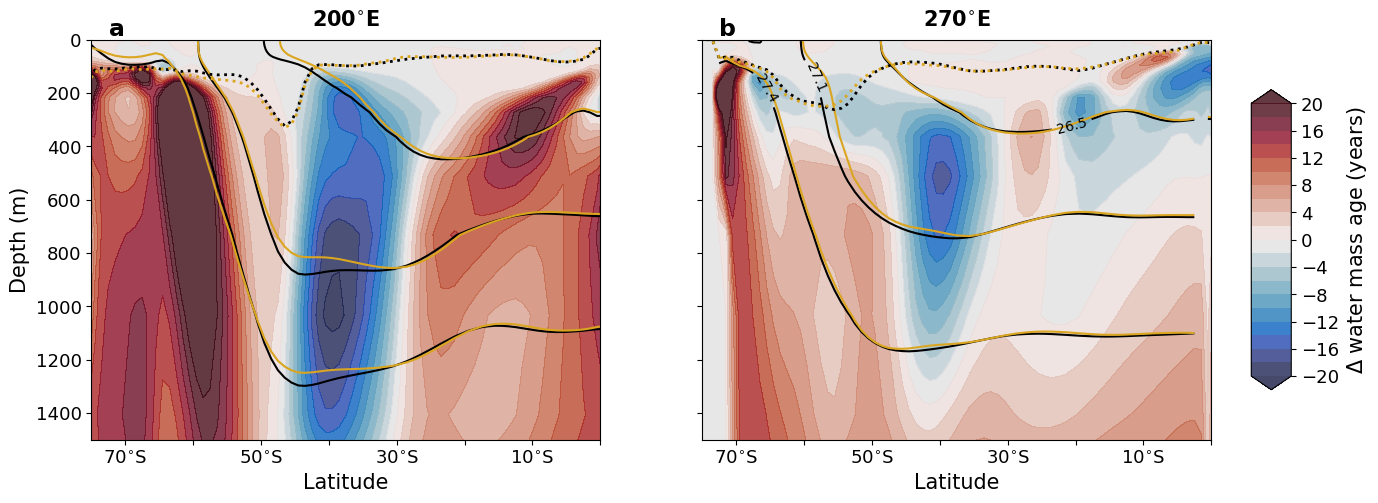

In [145]:
# get coordinates
lat_reg = ds_out.coords['lat'].isel(x=0).values
deps = age.coords['deptht'].values

# set plotting values
east = 270 - 180
west = 200 - 180
levs1 = np.arange(-20,21,2)
colmap1 = lighten(cmo.balance, 0.8)
fstic = 13
fslab = 15
cols = ['k', 'goldenrod']
lwid = [1.0, 2.0]
lsty = ['-', ':']
alf = [1.0, 1.0]

# create figure
fig = plt.figure(figsize=(16,5), facecolor='w')
gs = GridSpec(1,2)

# create axes
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax2.tick_params(labelleft=False)

# plot data
p1 = ax1.contourf(lat_reg, deps, (age.isel(year=slice(-20,65), x=west).mean(dim='year') - age.isel(year=slice(0,20), x=west).mean(dim='year')), \
                  levels=levs1, cmap=colmap1, vmin=np.min(levs1), vmax=np.max(levs1), extend='both')
c1a = ax1.contour(lat_reg, deps, rho0.isel(year=slice(-20,65), x=west).mean(dim=['year','month']), levels=[26.5, 27.1, 27.4], colors=cols[0], linewidth=lwid[0], linestyle=lsty[0], alpha=alf[0])
c1b = ax1.contour(lat_reg, deps, rho0.isel(year=slice(0,20), x=west).mean(dim=['year','month']), levels=[26.5, 27.1, 27.4], colors=cols[1], linewidth=lwid[0], linestyle=lsty[0], alpha=alf[0])
c1c = ax1.plot(lat_reg, mld.isel(year=slice(-20,65), x=west).mean(dim=['year']).max(dim='month'), color=cols[0], linewidth=lwid[1], linestyle=lsty[1], alpha=alf[1])
c1d = ax1.plot(lat_reg, mld.isel(year=slice(0,20), x=west).mean(dim=['year']).max(dim='month'), color=cols[1], linewidth=lwid[1], linestyle=lsty[1], alpha=alf[1])

p2 = ax2.contourf(lat_reg, deps, (age.isel(year=slice(-20,65), x=east).mean(dim='year') - age.isel(year=slice(0,20), x=east).mean(dim='year')), \
                  levels=levs1, cmap=colmap1, vmin=np.min(levs1), vmax=np.max(levs1), extend='both')
c2a = ax2.contour(lat_reg, deps, rho0.isel(year=slice(-20,65), x=east).mean(dim=['year','month']), levels=[26.5, 27.1, 27.4], colors=cols[0], linewidth=lwid[0], linestyle=lsty[0], alpha=alf[0])
c2b = ax2.contour(lat_reg, deps, rho0.isel(year=slice(0,20), x=east).mean(dim=['year','month']), levels=[26.5, 27.1, 27.4], colors=cols[1], linewidth=lwid[0], linestyle=lsty[0], alpha=alf[0])
c2c = ax2.plot(lat_reg, mld.isel(year=slice(-20,65), x=east).mean(dim=['year']).max(dim='month'), color=cols[0], linewidth=lwid[1], linestyle=lsty[1], alpha=alf[1])
c2d = ax2.plot(lat_reg, mld.isel(year=slice(0,20), x=east).mean(dim=['year']).max(dim='month'), color=cols[1], linewidth=lwid[1], linestyle=lsty[1], alpha=alf[1])

x1 = -75; x2 = 0
y1 = 1500; y2 = 0
ax1.set_xlim(x1,x2); ax1.set_ylim(y1,y2)
ax2.set_xlim(x1,x2); ax2.set_ylim(y1,y2)


x1 = np.arange(-70,1,10); x2 = np.array(["70$^{\circ}$S", " ", "50$^{\circ}$S", " ", "30$^{\circ}$S", " ", "10$^{\circ}$S", " " ])
y1 = np.arange(1400,-1,-200); y2 = np.arange(1400,-1,-200)
ax1.set_xticks(x1,x2, fontsize=fstic); ax1.set_yticks(y1,y2, fontsize=fstic)
ax2.set_xticks(x1,x2, fontsize=fstic); ax2.set_yticks(y1,y2, fontsize=fstic)

xx = 0.5; yy = 1.05
plt.text(xx,yy,'200$^{\circ}$E', fontsize=fslab, va='center', ha='center', fontweight='bold', transform=ax1.transAxes)
plt.text(xx,yy,'270$^{\circ}$E', fontsize=fslab, va='center', ha='center', fontweight='bold', transform=ax2.transAxes)

xx = 0.05; yy = 1.025
plt.text(xx,yy,'a', fontsize=fslab+2, va='center', ha='center', fontweight='bold', transform=ax1.transAxes)
plt.text(xx,yy,'b', fontsize=fslab+2, va='center', ha='center', fontweight='bold', transform=ax2.transAxes)

ax1.set_ylabel("Depth (m)", fontsize=fslab)
ax1.set_xlabel("Latitude", fontsize=fslab)
ax2.set_xlabel("Latitude", fontsize=fslab)

plt.subplots_adjust(left=0.15, top=0.9, bottom=0.1, right=0.85)

cbax1 = fig.add_axes([0.875,0.2,0.025,0.6])
cbar1 = plt.colorbar(p1, cax=cbax1, orientation='vertical', ticks=levs1[::2])
cbar1.ax.set_ylabel("$\Delta$ water mass age (years)", fontsize=fslab)
cbar1.ax.tick_params(labelsize=fstic)

#plt.clabel(c1a, manual=False, fontsize=11)
plt.clabel(c2a, manual=False)



# Save

In [13]:
os.chdir("/home/pbuchanan/analysis_samw")
fig.savefig("fig-meridional_Pacific.png", dpi=300)
fig.savefig("fig-meridional_Pacific.png", dpi=300, transparent=True)

# Plot the same thing but in the Indian basin

/scratch/pbuchanan/job_32417322/ipykernel_162504/353402916.py:29: UserWarning: The following kwargs were not used by contour: 'linewidth', 'linestyle'
  c1a = ax1.contour(lat_reg, deps, rho0.isel(year=slice(-20,65), x=west).mean(dim=['year','month']), levels=[26.5, 27.1, 27.4], colors=cols[0], linewidth=lwid[0], linestyle=lsty[0], alpha=alf[0])
/scratch/pbuchanan/job_32417322/ipykernel_162504/353402916.py:30: UserWarning: The following kwargs were not used by contour: 'linewidth', 'linestyle'
  c1b = ax1.contour(lat_reg, deps, rho0.isel(year=slice(0,20), x=west).mean(dim=['year','month']), levels=[26.5, 27.1, 27.4], colors=cols[1], linewidth=lwid[0], linestyle=lsty[0], alpha=alf[0])
/scratch/pbuchanan/job_32417322/ipykernel_162504/353402916.py:36: UserWarning: The following kwargs were not used by contour: 'linewidth', 'linestyle'
  c2a = ax2.contour(lat_reg, deps, rho0.isel(year=slice(-20,65), x=east).mean(dim=['year','month']), levels=[26.5, 27.1, 27.4], colors=cols[0], linewidth=lwi

<a list of 9 text.Text objects>

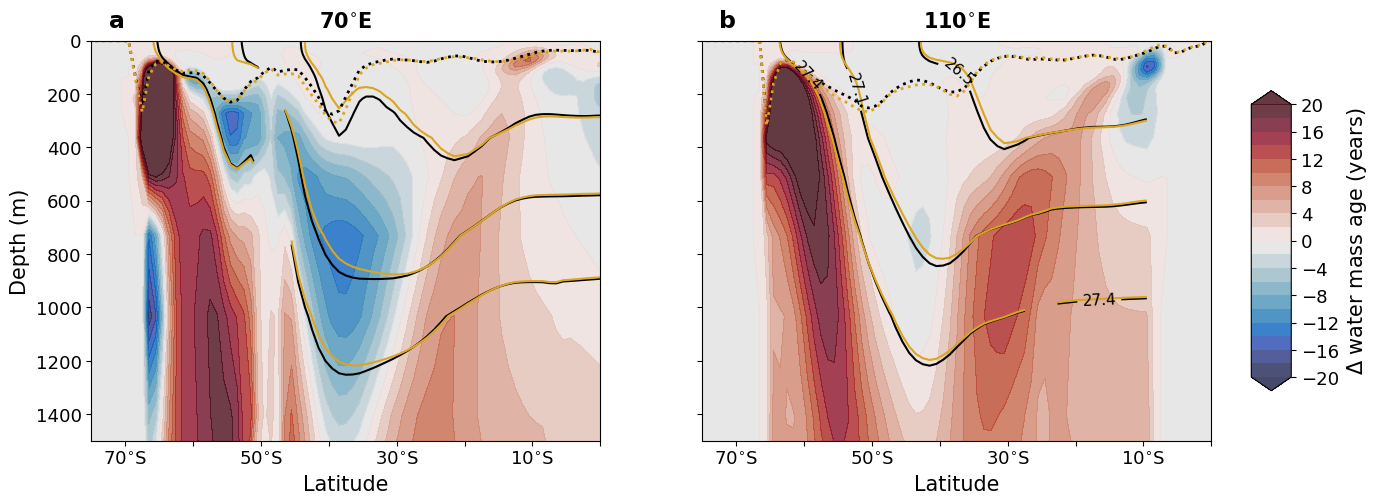

In [85]:
# get coordinates
lat_reg = ds_out.coords['lat'].isel(x=0).values
deps = age.coords['deptht'].values

# set plotting values
east = 110 + 180
west = 70 + 180
levs1 = np.arange(-20,21,2)
colmap1 = lighten(cmo.balance, 0.8)
fstic = 13
fslab = 15
cols = ['k', 'goldenrod']
lwid = [1.0, 2.0]
lsty = ['-', ':']
alf = [1.0, 1.0]

# create figure
fig = plt.figure(figsize=(16,5), facecolor='w')
gs = GridSpec(1,2)

# create axes
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax2.tick_params(labelleft=False)

# plot data
p1 = ax1.contourf(lat_reg, deps, age.isel(year=slice(-20,65), x=west).mean(dim='year') - age.isel(year=slice(0,20), x=west).mean(dim='year'), \
                  levels=levs1, cmap=colmap1, vmin=np.min(levs1), vmax=np.max(levs1), extend='both')
c1a = ax1.contour(lat_reg, deps, rho0.isel(year=slice(-20,65), x=west).mean(dim=['year','month']), levels=[26.5, 27.1, 27.4], colors=cols[0], linewidth=lwid[0], linestyle=lsty[0], alpha=alf[0])
c1b = ax1.contour(lat_reg, deps, rho0.isel(year=slice(0,20), x=west).mean(dim=['year','month']), levels=[26.5, 27.1, 27.4], colors=cols[1], linewidth=lwid[0], linestyle=lsty[0], alpha=alf[0])
c1c = ax1.plot(lat_reg, mld.isel(year=slice(-20,65), x=west).mean(dim=['year']).max(dim='month'), color=cols[0], linewidth=lwid[1], linestyle=lsty[1], alpha=alf[1])
c1d = ax1.plot(lat_reg, mld.isel(year=slice(0,20), x=west).mean(dim=['year']).max(dim='month'), color=cols[1], linewidth=lwid[1], linestyle=lsty[1], alpha=alf[1])

p2 = ax2.contourf(lat_reg, deps, age.isel(year=slice(-20,65), x=east).mean(dim='year') - age.isel(year=slice(0,20), x=east).mean(dim='year'), \
                  levels=levs1, cmap=colmap1, vmin=np.min(levs1), vmax=np.max(levs1), extend='both')
c2a = ax2.contour(lat_reg, deps, rho0.isel(year=slice(-20,65), x=east).mean(dim=['year','month']), levels=[26.5, 27.1, 27.4], colors=cols[0], linewidth=lwid[0], linestyle=lsty[0], alpha=alf[0])
c2b = ax2.contour(lat_reg, deps, rho0.isel(year=slice(0,20), x=east).mean(dim=['year','month']), levels=[26.5, 27.1, 27.4], colors=cols[1], linewidth=lwid[0], linestyle=lsty[0], alpha=alf[0])
c2c = ax2.plot(lat_reg, mld.isel(year=slice(-20,65), x=east).mean(dim=['year']).max(dim='month'), color=cols[0], linewidth=lwid[1], linestyle=lsty[1], alpha=alf[1])
c2d = ax2.plot(lat_reg, mld.isel(year=slice(0,20), x=east).mean(dim=['year']).max(dim='month'), color=cols[1], linewidth=lwid[1], linestyle=lsty[1], alpha=alf[1])


x1 = -75; x2 = 0
y1 = 1500; y2 = 0
ax1.set_xlim(x1,x2); ax1.set_ylim(y1,y2)
ax2.set_xlim(x1,x2); ax2.set_ylim(y1,y2)


x1 = np.arange(-70,1,10); x2 = np.array(["70$^{\circ}$S", " ", "50$^{\circ}$S", " ", "30$^{\circ}$S", " ", "10$^{\circ}$S", " " ])
y1 = np.arange(1400,-1,-200); y2 = np.arange(1400,-1,-200)
ax1.set_xticks(x1,x2, fontsize=fstic); ax1.set_yticks(y1,y2, fontsize=fstic)
ax2.set_xticks(x1,x2, fontsize=fstic); ax2.set_yticks(y1,y2, fontsize=fstic)

xx = 0.5; yy = 1.05
plt.text(xx,yy,'70$^{\circ}$E', fontsize=fslab, va='center', ha='center', fontweight='bold', transform=ax1.transAxes)
plt.text(xx,yy,'110$^{\circ}$E', fontsize=fslab, va='center', ha='center', fontweight='bold', transform=ax2.transAxes)

xx = 0.05; yy = 1.05
plt.text(xx,yy,'a', fontsize=fslab+2, va='center', ha='center', fontweight='bold', transform=ax1.transAxes)
plt.text(xx,yy,'b', fontsize=fslab+2, va='center', ha='center', fontweight='bold', transform=ax2.transAxes)

ax1.set_ylabel("Depth (m)", fontsize=fslab)
ax1.set_xlabel("Latitude", fontsize=fslab)
ax2.set_xlabel("Latitude", fontsize=fslab)

plt.subplots_adjust(left=0.15, top=0.9, bottom=0.1, right=0.85)

cbax1 = fig.add_axes([0.875,0.2,0.025,0.6])
cbar1 = plt.colorbar(p1, cax=cbax1, orientation='vertical', ticks=levs1[::2])
cbar1.ax.set_ylabel("$\Delta$ water mass age (years)", fontsize=fslab)
cbar1.ax.tick_params(labelsize=fstic)

plt.clabel(c2a, manual=False, fontsize=11)


# Save

In [86]:
os.chdir("/home/pbuchanan/analysis_samw")
fig.savefig("fig-meridional_Indian.png", dpi=300)
fig.savefig("fig-meridional_Indian.png", dpi=300, transparent=True)


# SE versus SW Pacific simulations

/scratch/pbuchanan/job_32417322/ipykernel_162504/1529414537.py:29: UserWarning: The following kwargs were not used by contour: 'linewidth', 'linestyle'
  c1a = ax1.contour(lat_reg, deps, rho0_SEpac.isel(x=west).mean(dim=['month']), levels=[26.5, 27.1, 27.4], colors=cols[0], linewidth=lwid[0], linestyle=lsty[0], alpha=alf[0])
/scratch/pbuchanan/job_32417322/ipykernel_162504/1529414537.py:30: UserWarning: The following kwargs were not used by contour: 'linewidth', 'linestyle'
  c1b = ax1.contour(lat_reg, deps, rho0_SWpac.isel(x=west).mean(dim=['month']), levels=[26.5, 27.1, 27.4], colors=cols[1], linewidth=lwid[0], linestyle=lsty[0], alpha=alf[0])
/scratch/pbuchanan/job_32417322/ipykernel_162504/1529414537.py:37: UserWarning: The following kwargs were not used by contour: 'linewidth', 'linestyle'
  c2a = ax2.contour(lat_reg, deps, rho0_SEpac.isel(x=east).mean(dim=['month']), levels=[26.5, 27.1, 27.4], colors=cols[0], linewidth=lwid[0], linestyle=lsty[0], alpha=alf[0])
/scratch/pbuchanan/

<a list of 9 text.Text objects>

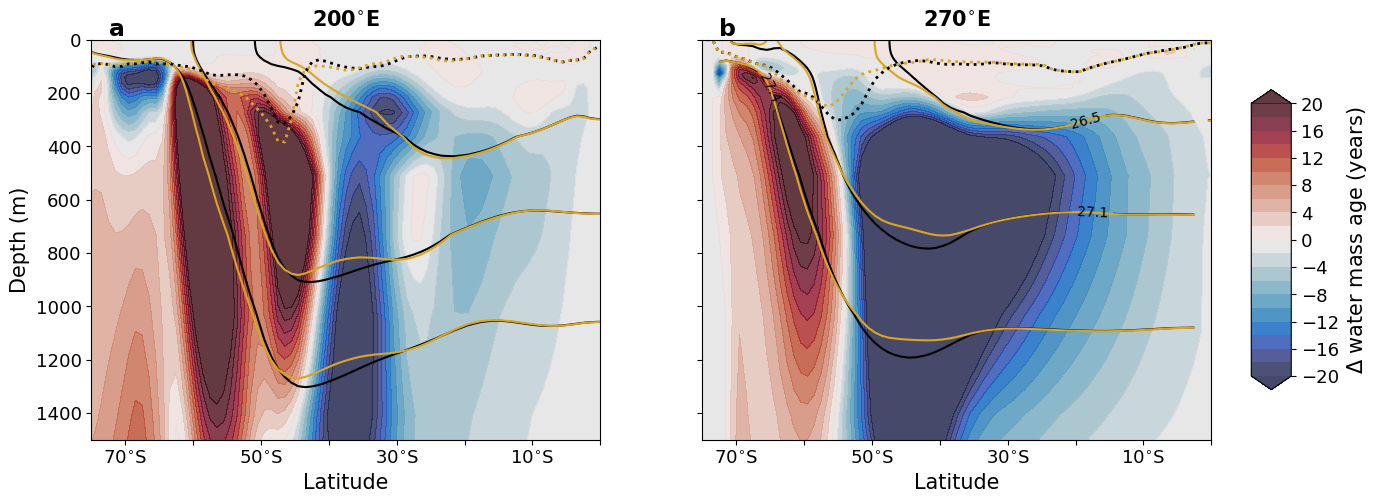

In [88]:
# get coordinates
lat_reg = ds_out.coords['lat'].isel(x=0).values
deps = age.coords['deptht'].values

# set plotting values
east = 270 - 180
west = 200 - 180
levs1 = np.arange(-20,21,2)
colmap1 = lighten(cmo.balance, 0.8)
fstic = 13
fslab = 15
cols = ['k', 'goldenrod']
lwid = [1.0, 2.0]
lsty = ['-', ':']
alf = [1.0, 1.0]

# create figure
fig = plt.figure(figsize=(16,5), facecolor='w')
gs = GridSpec(1,2)

# create axes
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax2.tick_params(labelleft=False)

# plot data
p1 = ax1.contourf(lat_reg, deps, age_SEpac.isel(year=64, x=west) - age_SWpac.isel(year=64, x=west), \
                  levels=levs1, cmap=colmap1, vmin=np.min(levs1), vmax=np.max(levs1), extend='both')
c1a = ax1.contour(lat_reg, deps, rho0_SEpac.isel(x=west).mean(dim=['month']), levels=[26.5, 27.1, 27.4], colors=cols[0], linewidth=lwid[0], linestyle=lsty[0], alpha=alf[0])
c1b = ax1.contour(lat_reg, deps, rho0_SWpac.isel(x=west).mean(dim=['month']), levels=[26.5, 27.1, 27.4], colors=cols[1], linewidth=lwid[0], linestyle=lsty[0], alpha=alf[0])
c1c = ax1.plot(lat_reg, mld_SEpac.isel(x=west).max(dim='month'), color=cols[0], linewidth=lwid[1], linestyle=lsty[1], alpha=alf[1])
c1d = ax1.plot(lat_reg, mld_SWpac.isel(x=west).max(dim='month'), color=cols[1], linewidth=lwid[1], linestyle=lsty[1], alpha=alf[1])


p2 = ax2.contourf(lat_reg, deps, age_SEpac.isel(year=64, x=east) - age_SWpac.isel(year=64, x=east), \
                  levels=levs1, cmap=colmap1, vmin=np.min(levs1), vmax=np.max(levs1), extend='both')
c2a = ax2.contour(lat_reg, deps, rho0_SEpac.isel(x=east).mean(dim=['month']), levels=[26.5, 27.1, 27.4], colors=cols[0], linewidth=lwid[0], linestyle=lsty[0], alpha=alf[0])
c2b = ax2.contour(lat_reg, deps, rho0_SWpac.isel(x=east).mean(dim=['month']), levels=[26.5, 27.1, 27.4], colors=cols[1], linewidth=lwid[0], linestyle=lsty[0], alpha=alf[0])
c2c = ax2.plot(lat_reg, mld_SEpac.isel(x=east).max(dim='month'), color=cols[0], linewidth=lwid[1], linestyle=lsty[1], alpha=alf[1])
c2d = ax2.plot(lat_reg, mld_SWpac.isel(x=east).max(dim='month'), color=cols[1], linewidth=lwid[1], linestyle=lsty[1], alpha=alf[1])


x1 = -75; x2 = 0
y1 = 1500; y2 = 0
ax1.set_xlim(x1,x2); ax1.set_ylim(y1,y2)
ax2.set_xlim(x1,x2); ax2.set_ylim(y1,y2)


x1 = np.arange(-70,1,10); x2 = np.array(["70$^{\circ}$S", " ", "50$^{\circ}$S", " ", "30$^{\circ}$S", " ", "10$^{\circ}$S", " " ])
y1 = np.arange(1400,-1,-200); y2 = np.arange(1400,-1,-200)
ax1.set_xticks(x1,x2, fontsize=fstic); ax1.set_yticks(y1,y2, fontsize=fstic)
ax2.set_xticks(x1,x2, fontsize=fstic); ax2.set_yticks(y1,y2, fontsize=fstic)

xx = 0.5; yy = 1.05
plt.text(xx,yy,'200$^{\circ}$E', fontsize=fslab, va='center', ha='center', fontweight='bold', transform=ax1.transAxes)
plt.text(xx,yy,'270$^{\circ}$E', fontsize=fslab, va='center', ha='center', fontweight='bold', transform=ax2.transAxes)

xx = 0.05; yy = 1.025
plt.text(xx,yy,'a', fontsize=fslab+2, va='center', ha='center', fontweight='bold', transform=ax1.transAxes)
plt.text(xx,yy,'b', fontsize=fslab+2, va='center', ha='center', fontweight='bold', transform=ax2.transAxes)

ax1.set_ylabel("Depth (m)", fontsize=fslab)
ax1.set_xlabel("Latitude", fontsize=fslab)
ax2.set_xlabel("Latitude", fontsize=fslab)

plt.subplots_adjust(left=0.15, top=0.9, bottom=0.1, right=0.85)

cbax1 = fig.add_axes([0.875,0.2,0.025,0.6])
cbar1 = plt.colorbar(p1, cax=cbax1, orientation='vertical', ticks=levs1[::2])
cbar1.ax.set_ylabel("$\Delta$ water mass age (years)", fontsize=fslab)
cbar1.ax.tick_params(labelsize=fstic)

#plt.clabel(c1a, manual=False, fontsize=11)
plt.clabel(c2a, manual=False)


# Save

In [82]:
os.chdir("/home/pbuchanan/analysis_samw")
fig.savefig("fig-meridional_SEvSW_Pacific.png", dpi=300)
fig.savefig("fig-meridional_SEvSW_Pacific.png", dpi=300, transparent=True)

# Now for the Indian SE v SW experiments

/scratch/pbuchanan/job_32417322/ipykernel_162504/2358895466.py:29: UserWarning: The following kwargs were not used by contour: 'linewidth', 'linestyle'
  c1a = ax1.contour(lat_reg, deps, rho0_SEind.isel(x=west).mean(dim=['month']), levels=[26.5, 27.1, 27.4], colors=cols[0], linewidth=lwid[0], linestyle=lsty[0], alpha=alf[0])
/scratch/pbuchanan/job_32417322/ipykernel_162504/2358895466.py:30: UserWarning: The following kwargs were not used by contour: 'linewidth', 'linestyle'
  c1b = ax1.contour(lat_reg, deps, rho0_SWind.isel(x=west).mean(dim=['month']), levels=[26.5, 27.1, 27.4], colors=cols[1], linewidth=lwid[0], linestyle=lsty[0], alpha=alf[0])
/scratch/pbuchanan/job_32417322/ipykernel_162504/2358895466.py:37: UserWarning: The following kwargs were not used by contour: 'linewidth', 'linestyle'
  c2a = ax2.contour(lat_reg, deps, rho0_SEind.isel(x=east).mean(dim=['month']), levels=[26.5, 27.1, 27.4], colors=cols[0], linewidth=lwid[0], linestyle=lsty[0], alpha=alf[0])
/scratch/pbuchanan/

<a list of 9 text.Text objects>

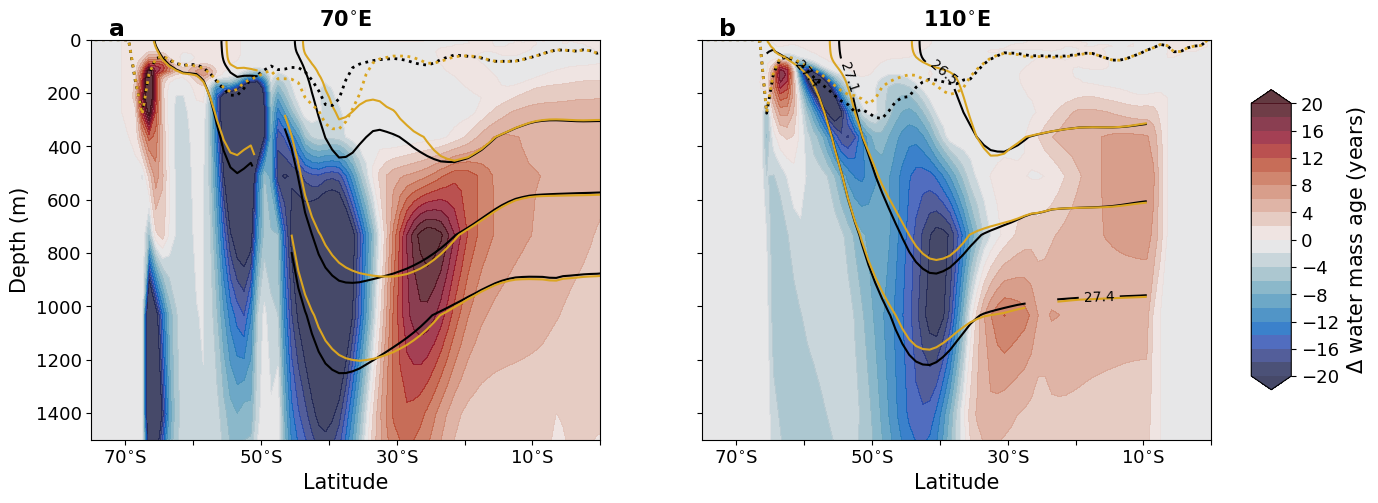

In [83]:
# get coordinates
lat_reg = ds_out.coords['lat'].isel(x=0).values
deps = age.coords['deptht'].values

# set plotting values
east = 110 + 180
west = 70 + 180
levs1 = np.arange(-20,21,2)
colmap1 = lighten(cmo.balance, 0.8)
fstic = 13
fslab = 15
cols = ['k', 'goldenrod']
lwid = [1.0, 2.0]
lsty = ['-', ':']
alf = [1.0, 1.0]

# create figure
fig = plt.figure(figsize=(16,5), facecolor='w')
gs = GridSpec(1,2)

# create axes
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax2.tick_params(labelleft=False)

# plot data
p1 = ax1.contourf(lat_reg, deps, age_SEind.isel(year=64, x=west) - age_SWind.isel(year=64, x=west), \
                  levels=levs1, cmap=colmap1, vmin=np.min(levs1), vmax=np.max(levs1), extend='both')
c1a = ax1.contour(lat_reg, deps, rho0_SEind.isel(x=west).mean(dim=['month']), levels=[26.5, 27.1, 27.4], colors=cols[0], linewidth=lwid[0], linestyle=lsty[0], alpha=alf[0])
c1b = ax1.contour(lat_reg, deps, rho0_SWind.isel(x=west).mean(dim=['month']), levels=[26.5, 27.1, 27.4], colors=cols[1], linewidth=lwid[0], linestyle=lsty[0], alpha=alf[0])
c1c = ax1.plot(lat_reg, mld_SEind.isel(x=west).max(dim='month'), color=cols[0], linewidth=lwid[1], linestyle=lsty[1], alpha=alf[1])
c1d = ax1.plot(lat_reg, mld_SWind.isel(x=west).max(dim='month'), color=cols[1], linewidth=lwid[1], linestyle=lsty[1], alpha=alf[1])


p2 = ax2.contourf(lat_reg, deps, age_SEind.isel(year=64, x=east) - age_SWind.isel(year=64, x=east), \
                  levels=levs1, cmap=colmap1, vmin=np.min(levs1), vmax=np.max(levs1), extend='both')
c2a = ax2.contour(lat_reg, deps, rho0_SEind.isel(x=east).mean(dim=['month']), levels=[26.5, 27.1, 27.4], colors=cols[0], linewidth=lwid[0], linestyle=lsty[0], alpha=alf[0])
c2b = ax2.contour(lat_reg, deps, rho0_SWind.isel(x=east).mean(dim=['month']), levels=[26.5, 27.1, 27.4], colors=cols[1], linewidth=lwid[0], linestyle=lsty[0], alpha=alf[0])
c2c = ax2.plot(lat_reg, mld_SEind.isel(x=east).max(dim='month'), color=cols[0], linewidth=lwid[1], linestyle=lsty[1], alpha=alf[1])
c2d = ax2.plot(lat_reg, mld_SWind.isel(x=east).max(dim='month'), color=cols[1], linewidth=lwid[1], linestyle=lsty[1], alpha=alf[1])


x1 = -75; x2 = 0
y1 = 1500; y2 = 0
ax1.set_xlim(x1,x2); ax1.set_ylim(y1,y2)
ax2.set_xlim(x1,x2); ax2.set_ylim(y1,y2)


x1 = np.arange(-70,1,10); x2 = np.array(["70$^{\circ}$S", " ", "50$^{\circ}$S", " ", "30$^{\circ}$S", " ", "10$^{\circ}$S", " " ])
y1 = np.arange(1400,-1,-200); y2 = np.arange(1400,-1,-200)
ax1.set_xticks(x1,x2, fontsize=fstic); ax1.set_yticks(y1,y2, fontsize=fstic)
ax2.set_xticks(x1,x2, fontsize=fstic); ax2.set_yticks(y1,y2, fontsize=fstic)

xx = 0.5; yy = 1.05
plt.text(xx,yy,'70$^{\circ}$E', fontsize=fslab, va='center', ha='center', fontweight='bold', transform=ax1.transAxes)
plt.text(xx,yy,'110$^{\circ}$E', fontsize=fslab, va='center', ha='center', fontweight='bold', transform=ax2.transAxes)

xx = 0.05; yy = 1.025
plt.text(xx,yy,'a', fontsize=fslab+2, va='center', ha='center', fontweight='bold', transform=ax1.transAxes)
plt.text(xx,yy,'b', fontsize=fslab+2, va='center', ha='center', fontweight='bold', transform=ax2.transAxes)

ax1.set_ylabel("Depth (m)", fontsize=fslab)
ax1.set_xlabel("Latitude", fontsize=fslab)
ax2.set_xlabel("Latitude", fontsize=fslab)

plt.subplots_adjust(left=0.15, top=0.9, bottom=0.1, right=0.85)

cbax1 = fig.add_axes([0.875,0.2,0.025,0.6])
cbar1 = plt.colorbar(p1, cax=cbax1, orientation='vertical', ticks=levs1[::2])
cbar1.ax.set_ylabel("$\Delta$ water mass age (years)", fontsize=fslab)
cbar1.ax.tick_params(labelsize=fstic)

#plt.clabel(c1a, manual=False, fontsize=11)
plt.clabel(c2a, manual=False)


# Save

In [84]:
os.chdir("/home/pbuchanan/analysis_samw")
fig.savefig("fig-meridional_SEvSW_Indian.png", dpi=300)
fig.savefig("fig-meridional_SEvSW_Indian.png", dpi=300, transparent=True)

# What is the deep ocean trend when we hold the surface forcing constant?

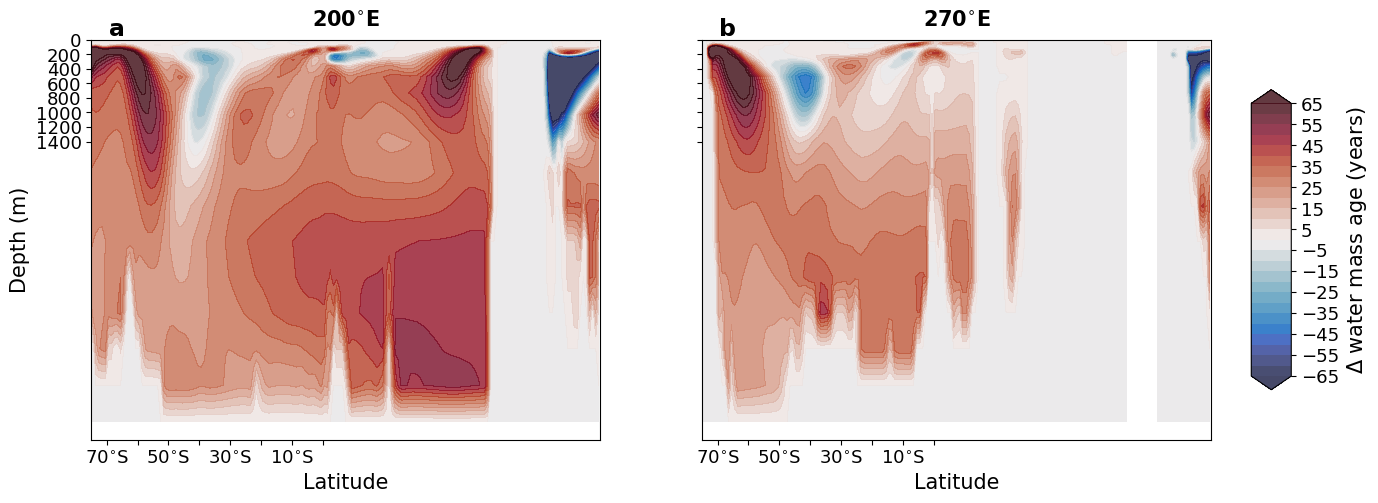

In [94]:
# get coordinates
lat_reg = ds_out.coords['lat'].isel(x=0).values
deps = age.coords['deptht'].values

# set plotting values
east = 270 - 180
west = 200 - 180
levs1 = np.arange(-65,66,5)
colmap1 = lighten(cmo.balance, 0.8)
fstic = 13
fslab = 15
cols = ['k', 'goldenrod']
lwid = [1.0, 2.0]
lsty = ['-', ':']
alf = [1.0, 1.0]

# create figure
fig = plt.figure(figsize=(16,5), facecolor='w')
gs = GridSpec(1,2)

# create axes
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax2.tick_params(labelleft=False)

# plot data
p1 = ax1.contourf(lat_reg, deps, age_SEpac.isel(year=64, x=west) - age_SEpac.isel(year=0, x=west), \
                  levels=levs1, cmap=colmap1, vmin=np.min(levs1), vmax=np.max(levs1), extend='both')


p2 = ax2.contourf(lat_reg, deps, age_SEpac.isel(year=64, x=east) - age_SEpac.isel(year=0, x=east), \
                  levels=levs1, cmap=colmap1, vmin=np.min(levs1), vmax=np.max(levs1), extend='both')


x1 = -75; x2 = 90
y1 = 5500; y2 = 0
ax1.set_xlim(x1,x2); ax1.set_ylim(y1,y2)
ax2.set_xlim(x1,x2); ax2.set_ylim(y1,y2)


x1 = np.arange(-70,1,10); x2 = np.array(["70$^{\circ}$S", " ", "50$^{\circ}$S", " ", "30$^{\circ}$S", " ", "10$^{\circ}$S", " " ])
y1 = np.arange(1400,-1,-200); y2 = np.arange(1400,-1,-200)
ax1.set_xticks(x1,x2, fontsize=fstic); ax1.set_yticks(y1,y2, fontsize=fstic)
ax2.set_xticks(x1,x2, fontsize=fstic); ax2.set_yticks(y1,y2, fontsize=fstic)

xx = 0.5; yy = 1.05
plt.text(xx,yy,'200$^{\circ}$E', fontsize=fslab, va='center', ha='center', fontweight='bold', transform=ax1.transAxes)
plt.text(xx,yy,'270$^{\circ}$E', fontsize=fslab, va='center', ha='center', fontweight='bold', transform=ax2.transAxes)

xx = 0.05; yy = 1.025
plt.text(xx,yy,'a', fontsize=fslab+2, va='center', ha='center', fontweight='bold', transform=ax1.transAxes)
plt.text(xx,yy,'b', fontsize=fslab+2, va='center', ha='center', fontweight='bold', transform=ax2.transAxes)

ax1.set_ylabel("Depth (m)", fontsize=fslab)
ax1.set_xlabel("Latitude", fontsize=fslab)
ax2.set_xlabel("Latitude", fontsize=fslab)

plt.subplots_adjust(left=0.15, top=0.9, bottom=0.1, right=0.85)

cbax1 = fig.add_axes([0.875,0.2,0.025,0.6])
cbar1 = plt.colorbar(p1, cax=cbax1, orientation='vertical', ticks=levs1[::2])
cbar1.ax.set_ylabel("$\Delta$ water mass age (years)", fontsize=fslab)
cbar1.ax.tick_params(labelsize=fstic)
